# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions on the registry level.

Specifically, we consider the German registry with the identifier DE.

In [1]:
id_reg = "DE"

# Packages and options

In [2]:
from pyeutl.orm import DataAccessLayer       # data access layer to access the database
from pyeutl.orm import Country, Installation  # use country class to access registries
import pandas as pd
import matplotlib.pyplot as plt
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="postgres", 
    host="localhost", 
    db="eutl2024", 
    passw="password",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get registry

Given the registry id, use the session to get the registry:

In [5]:
registry = session.get(Country, id_reg)
print(registry.id + ": " + registry.name)

DE: Germany


# Installations

## Low-level access: Get installation objects

The country object has a property "installations_in_registry" which returns the query to get all installations registered in the country. The property "installations_in_country" returns all installations located in the country. 

In [6]:
inst = registry.installations_in_registry
inst

Given the query we can either fetch the results:

In [7]:
inst.first()          # get only first results
inst.all()            # get all results
inst.limit(5).all()   # get first 5 results 

[<Installation('DE_222293', 'DE_222293', <Country('DE', 'Germany')>)>,
 <Installation('DE_200110', '201', <Country('DE', 'Germany')>)>,
 <Installation('DE_200022', '1776', <Country('DE', 'Germany')>)>,
 <Installation('DE_200060', '21912', <Country('DE', 'Germany')>)>,
 <Installation('DE_200408', '25067', <Country('DE', 'Germany')>)>]

We could also further filter the results, e.g., getting all installations under activity 1 or 20 (combustion of fuels):

In [8]:
t_ = inst.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1536


## More easy: get_installations()

The low-level access is useful to directly get the installation objects which allows constructing different filters. For convenience, get_installations() implements a method that returns all installations in the registry as a Pandas dataframe.

In [9]:
inst = registry.get_installations()
inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131 entries, 0 to 3130
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   monitoringID            210 non-null    object        
 1   addressSecondary        202 non-null    object        
 2   latitudeEutl            11 non-null     float64       
 3   latitudeGoogle          2858 non-null   float64       
 4   isMaritimeOperator      3130 non-null   object        
 5   name                    3131 non-null   object        
 6   monitoringExpiry        0 non-null      object        
 7   postalCode              3129 non-null   object        
 8   longitudeGoogle         2858 non-null   float64       
 9   shippingCompanyCountry  238 non-null    object        
 10  id                      3131 non-null   object        
 11  monitoringFirstYear     210 non-null    object        
 12  city                    3130 non-null   object  

To get an overview about the number of activities we can use a simple groupby operation but need to to be aware that some installations do not have a Nace code assigned:

In [10]:
inst.groupby("nace", dropna=False)[["id"]].count().sort_values("id", ascending=False).head(5)

,id
nace,
Steam and air conditioning supply,598
Production of electricity,257
Water transport,238
Air transport,210
NaN,199


Most installations provide either heat or electricity (or both). The large number of NaN results from aircraft operators that do not have a nace code assigned: 

In [11]:
(
    inst[pd.isnull(inst.nace)]
    .groupby(["activity", "activity_id"])[["id"]]
    .count()
    .sort_values("id", ascending=False)
    .head(4)
)

,,id
activity,activity_id,
Combustion of fuels,20,96
Production of bulk chemicals,42,58
Combustion installations with a rated thermal input exceeding 20 MW,1,9
Production of paper or cardboard,36,7


The get_installation() method implements allows filtering installations based on installation attributes. For this, provide a dictionary with the installation attribute as key and a *list* as values. The dataframe returned only includes installations with attribute values as given in the respective list.

As an example, filter again for installations related to combustion activities:

In [12]:
filt = {"activity_id": [1, 20]}
t_ = registry.get_installations(filter=filt)
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1536


In [13]:
registry.get_installations(filter=filt).activity_id.unique()

array([20,  1], dtype=int64)

# Compliance

## Low-level: Using installation objects

Given a list of installation objects, we can analyze each installation in same manner as outline in the previous notebook. 

As an example, consider getting all compliance data for combustion activities in the selected registry:

In [14]:
comb = registry.installations_in_registry.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(comb))

Number of combustion installations:  1536


Now follow the previous notebook and get the compliance data:

In [15]:
df_comb = pd.concat([c.get_compliance() for c in comb])
df_comb.info()

C:\Users\abrel\AppData\Local\Temp\ipykernel_32564\1590394317.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comb = pd.concat([c.get_compliance() for c in comb])


<class 'pandas.core.frame.DataFrame'>
Index: 39936 entries, 0 to 25
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    39936 non-null  int64  
 1   euetsPhase              39936 non-null  object 
 2   allocatedNewEntrance    598 non-null    float64
 3   allocated10c            0 non-null      object 
 4   verifiedCummulative     20392 non-null  float64
 5   surrendered             19562 non-null  float64
 6   balance                 0 non-null      object 
 7   reportedInSystem_id     39936 non-null  object 
 8   installation_id         39936 non-null  object 
 9   compliance_id           20799 non-null  object 
 10  allocatedFree           21433 non-null  float64
 11  allocatedTotal          39936 non-null  int64  
 12  verified                20085 non-null  float64
 13  verifiedUpdated         39936 non-null  bool   
 14  surrenderedCummulative  20734 non-null  float6

Accessing data in this way, has the advantage to be rather flexible in allowing to access that data for each installation. However, that comes at performance cost. Moreover, you either need to join installation information like names and activities or to further aggregate the data. 

Therefore, the country object provides further methods that already include these information and aggregations.

## High level: get_compliance()

get_compliance() returns a dataframe of compliance data related to the registry including limited installation details:

In [16]:
df_comp = registry.get_compliance()
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83588 entries, 0 to 83587
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   installation_id       83588 non-null  object 
 1   installation_name     83588 non-null  object 
 2   activity_id           83588 non-null  int64  
 3   activity              83588 non-null  object 
 4   nace_id               78432 non-null  object 
 5   nace                  78432 non-null  object 
 6   year                  83588 non-null  int64  
 7   surrendered           33863 non-null  float64
 8   verified              35275 non-null  float64
 9   allocatedTotal        83588 non-null  int64  
 10  allocatedFree         38448 non-null  float64
 11  allocated10c          14 non-null     float64
 12  allocatedNewEntrance  1256 non-null   float64
 13  nace_category         83588 non-null  object 
 14  activity_category     83588 non-null  object 
dtypes: float64(5), int6

Note that the installation data contain a special installation, that represent the Effort Sharing performance of the respective registry. This installation is always named after the two-digit country identifier and then esd. This approach was chosen to fit the ESD data into the general data model. It allows to easily access the ESD compliance of the registry. We next use the ESD identifier to separate EUETS compliance data from those under the ESD:

In [17]:
id_inst_esd = f"{id_reg}_esd"
df_comp_esd = df_comp[df_comp.installation_id == id_inst_esd].copy()
df_comp_euets = df_comp[df_comp.installation_id != id_inst_esd].copy()
df_comp_euets

,installation_id,installation_name,activity_id,activity,nace_id,nace,year,surrendered,verified,allocatedTotal,allocatedFree,allocated10c,allocatedNewEntrance,nace_category,activity_category
0,DE_1501,Heizkraftwerk Mitte (Allerheiligenstraße),20,Combustion of fuels,35.30,Steam and air conditioning supply,2024,NaN,NaN,2700,2700.0,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
1,DE_1501,Heizkraftwerk Mitte (Allerheiligenstraße),20,Combustion of fuels,35.30,Steam and air conditioning supply,2025,NaN,NaN,2625,2625.0,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
2,DE_1501,Heizkraftwerk Mitte (Allerheiligenstraße),20,Combustion of fuels,35.30,Steam and air conditioning supply,2026,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
3,DE_1501,Heizkraftwerk Mitte (Allerheiligenstraße),20,Combustion of fuels,35.30,Steam and air conditioning supply,2027,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
4,DE_1501,Heizkraftwerk Mitte (Allerheiligenstraße),20,Combustion of fuels,35.30,Steam and air conditioning supply,2028,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83575,DE_200312,2758,10,Aircraft operator activities,51.0,Air transport,2026,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
83576,DE_200312,2758,10,Aircraft operator activities,51.0,Air transport,2027,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
83577,DE_200312,2758,10,Aircraft operator activities,51.0,Air transport,2028,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
83578,DE_200312,2758,10,Aircraft operator activities,51.0,Air transport,2029,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts


The frame allows to easily aggregate compliance data by the respective dimension. As an example, plot verified emissions by NACE category over time:

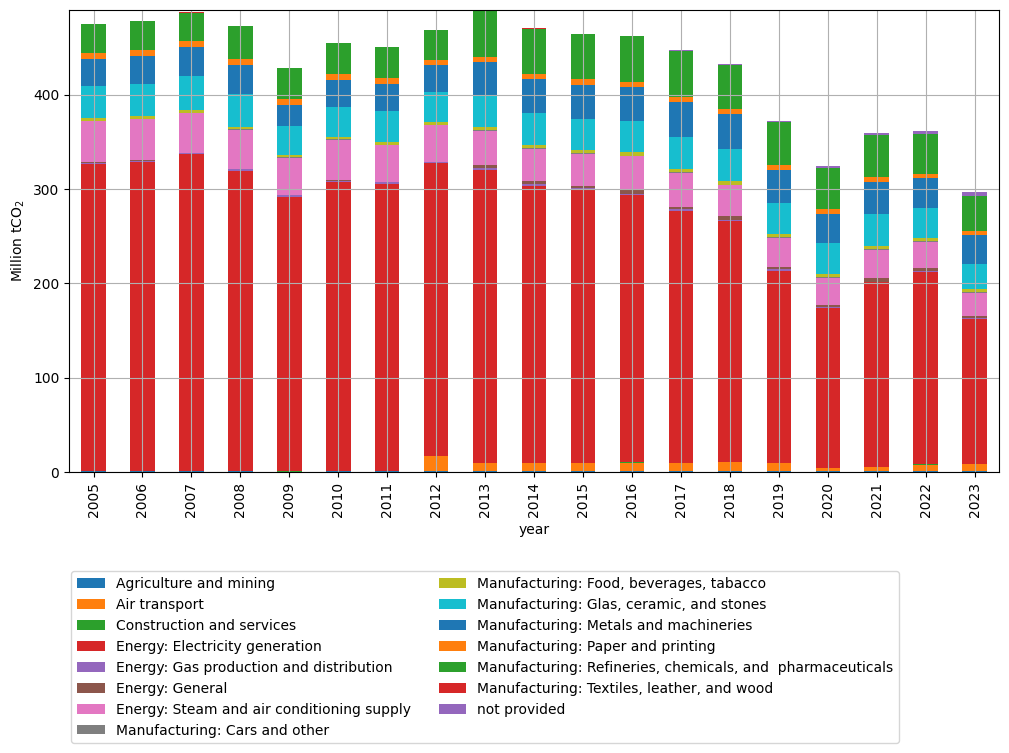

In [18]:
ax = (
    df_comp_euets
    .query("year < 2024")
    .groupby(["year", "nace_category"], as_index=False)
    .verified
    .sum()
    .pivot_table("verified", "year", "nace_category", dropna=False)
    .div(1000000)
    .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel="Million tCO$_2$", grid=True)
)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=2)

Likewise, by activity category:

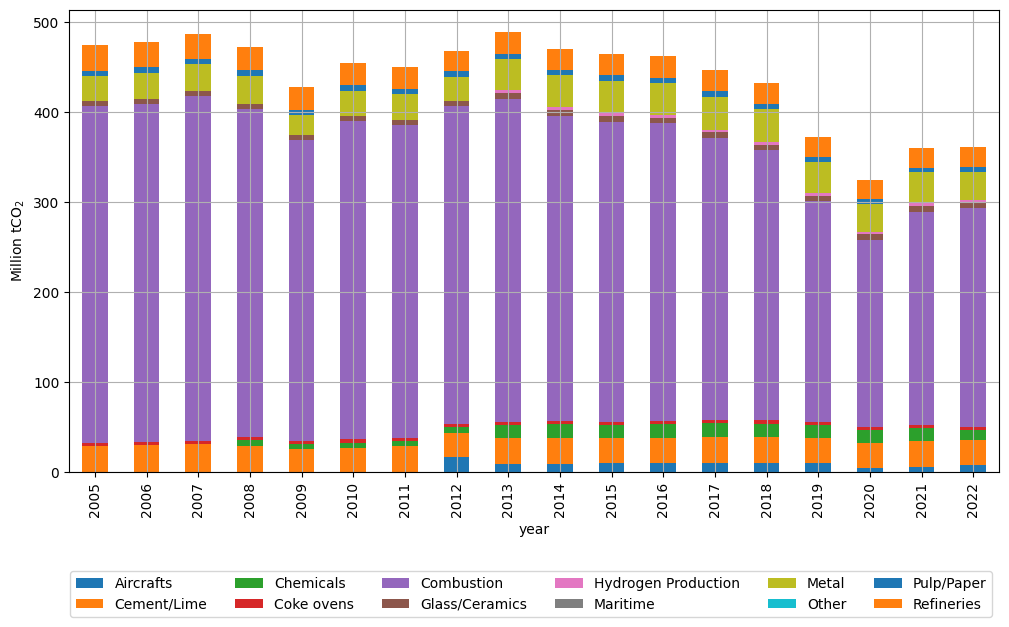

In [19]:
ax = (
    df_comp_euets
    .query("year < 2023").groupby(["year", "activity_category"], as_index=False)
    .verified.sum()
    .pivot_table("verified", "year", "activity_category", dropna=False).div(1000000)
    .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel="Million tCO$_2$", grid=True)
)
ax.legend(bbox_to_anchor=(1, -0.2), loc=0, ncol=6)

## Effort Sharing

For the effort sharing system we have only one installation and can directly plot emissions together with allocated and surrendered Assigned Amount Units (AAU)

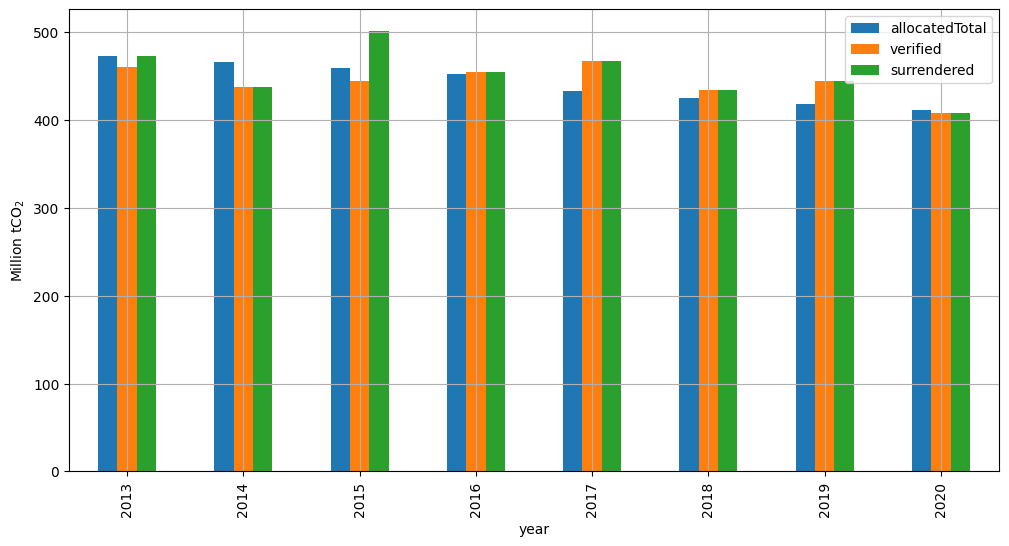

In [20]:
ax = ( 
    df_comp_esd
    .set_index("year")
    [["allocatedTotal", "verified", "surrendered"]]
    .div(1000000)
    .plot(kind="bar", stacked=False,  figsize=(12,6), ylabel="Million tCO$_2$", grid=True)
)

In [21]:
df_comp_esd.query("year < 2021").set_index("year")

,installation_id,installation_name,activity_id,activity,nace_id,nace,surrendered,verified,allocatedTotal,allocatedFree,allocated10c,allocatedNewEntrance,nace_category,activity_category
year,,,,,,,,,,,,,,
2013,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,472527651.0,460204908.0,472527651,NaN,NaN,NaN,not provided,not provided
2014,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,436790185.0,436790185.0,465830461,NaN,NaN,NaN,not provided,not provided
2015,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,500496290.0,444080615.0,459133271,NaN,NaN,NaN,not provided,not provided
2016,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,454157411.0,454157411.0,452436081,NaN,NaN,NaN,not provided,not provided
2017,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,466857281.0,466857281.0,432348857,NaN,NaN,NaN,not provided,not provided
2018,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,434047773.0,434047773.0,425202158,NaN,NaN,NaN,not provided,not provided
2019,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,444262722.0,444262722.0,418055459,NaN,NaN,NaN,not provided,not provided
2020,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,407410808.0,407410808.0,410908761,NaN,NaN,NaN,not provided,not provided


# Whole EUETS

Finally, we look at emissions at the full EUETS level by activity and industry:

In [22]:
registries = [i[0] for i in session.query(Country.id).all()]

In [23]:
lst_df = []
for reg in session.query(Country).all():
    id_inst_esd = f"{reg.id}_esd"
    df = (
        reg
        .get_compliance()
        .query("year < 2024")
        .query(f"installation_id != '{id_inst_esd}'")
        [["year", "nace_category", "activity_category", "verified"]]
    )
    lst_df.append(df)
df_comp = pd.concat(lst_df)

C:\Users\abrel\AppData\Local\Temp\ipykernel_32564\4051259630.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comp = pd.concat(lst_df)


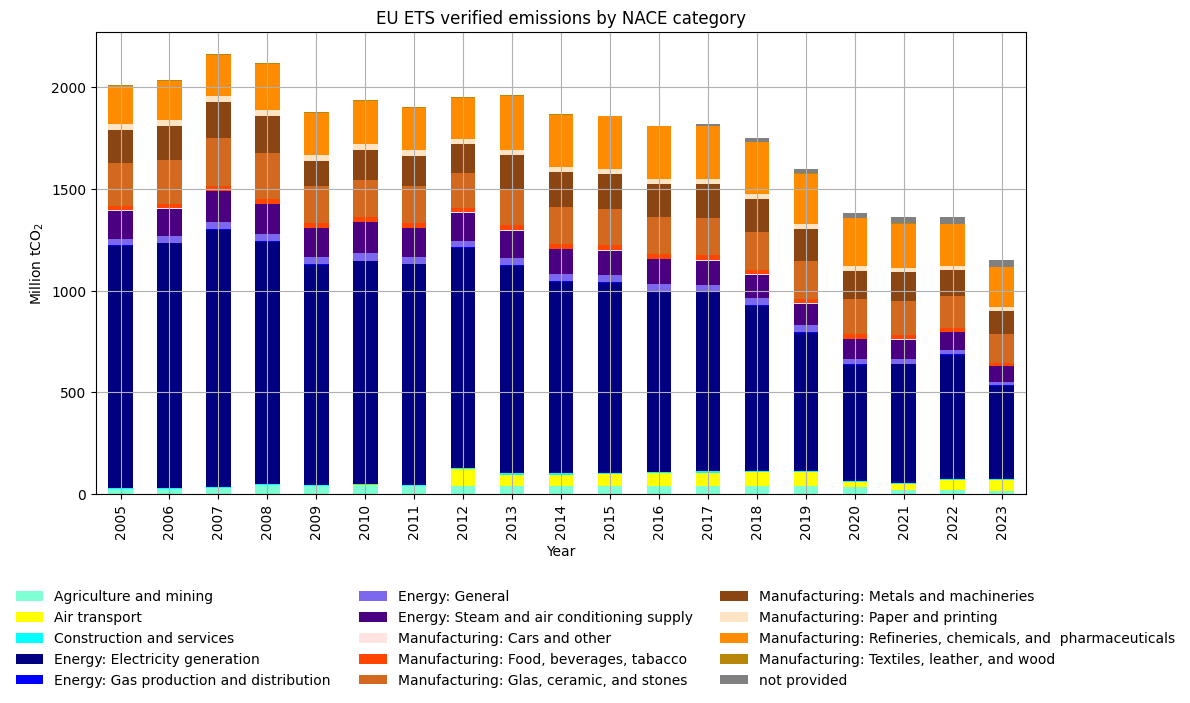

In [24]:
df_ = (
    df_comp
    .groupby(["year", "nace_category"], as_index=False)
    [["verified"]]
    .sum()
    .pivot_table("verified", "year", "nace_category", dropna=False)
    .div(1000000)
    
)
cm = plt.get_cmap('Spectral')
colors = [cm(1.*i/len(df_.columns)) for i in range(len(df_.columns))]
colors = {
    "Agriculture and mining": "aquamarine",
    "Air transport": "yellow",
    "Construction and services": "cyan",
    "Energy: Electricity generation": "navy",
    "Energy: Gas production and distribution": "blue",
    "Energy: General": "mediumslateblue",
    "Energy: Steam and air conditioning supply": "indigo",
    "Manufacturing: Cars and other": "mistyrose",
    "Manufacturing: Food, beverages, tabacco": "orangered",
    "Manufacturing: Glas, ceramic, and stones": "chocolate",
    "Manufacturing: Metals and machineries": "saddlebrown",
    "Manufacturing: Paper and printing": "bisque",
    "Manufacturing: Refineries, chemicals, and  pharmaceuticals": "darkorange",
    "Manufacturing: Textiles, leather, and wood": "darkgoldenrod",
    "not provided": "gray",
}
ax = df_.plot(kind="bar", stacked=True,  figsize=(12,6), 
         ylabel="Million tCO$_2$", xlabel="Year",
         grid=True, color=colors, title="EU ETS verified emissions by NACE category")
ax.set_ylim(0,None)
# move legend to the left outside the plot
plt.legend(bbox_to_anchor=(-0.1, -0.18), loc='upper left', ncol=3, frameon=False)
plt.savefig("EUETS_NACE_category.png", dpi=300, bbox_inches="tight")

And by activity

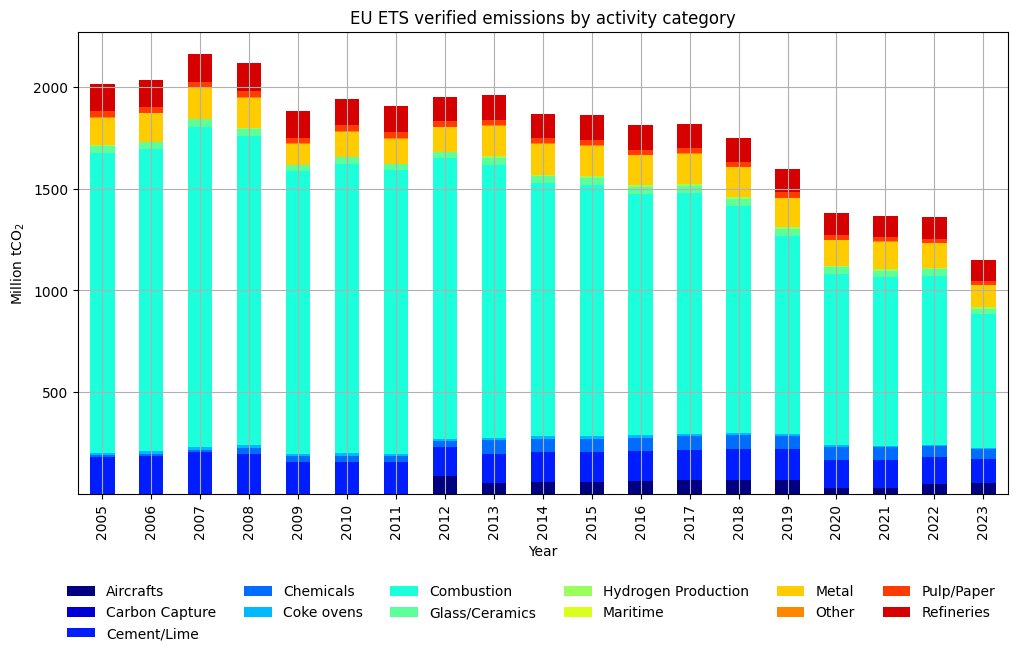

In [25]:
df_ = (
    df_comp
    .groupby(["year", "activity_category"], as_index=False)
    [["verified"]]
    .sum()
    .pivot_table("verified", "year", "activity_category", dropna=False)
    .div(1000000)
)
cm = plt.get_cmap('jet')
colors = [cm(1.*i/len(df_.columns)) for i in range(len(df_.columns))]
ax = df_.plot(
    kind="bar", stacked=True,  figsize=(12,6), 
    ylabel="Million tCO$_2$", xlabel="Year",
    grid=True,  title="EU ETS verified emissions by activity category",
    color=colors)
ax.legend(bbox_to_anchor=(1, -0.17), loc=0, ncol=6, frameon=False)
plt.savefig("EUETS_activity_category.png", dpi=300, bbox_inches="tight")